# Part 1: Genres and communities and plotting 

<div style="border: 1px solid white; padding: 10px;">

The questions below are based on Lecture 7, part 2.

* Write about genres and modularity.
* Detect the communities, discuss the value of modularity in comparison to the genres.
* Calculate the matrix $D$ and discuss your findings.
* Plot the communities and comment on your results.

</div>

<font color='skyblue'>Answer 1 Part 1: **Write about genres and modularity**</font>

Modularity is a measure that quantifies the quality of a particular partition of a network into communities, aiming to capture the strenght of connections within each community compared to what would be expected by random chance. It assesses whether nodes within the same community are more dansely connected to each other than to nodes in other comminities.

In a network with $N$ nodes and $L$ links, modularity $M$ for a given partition into $n_c$ communities is calculated by comparing the actual number of links within each community $C_c$ to the number we would expect if the network were randomly structured (while perserving each node's total degree or connectivity). For each community $C_c$ mosularity is defined as:

$$M_c = \frac{L_c}{L} - (\frac{K_c}{2L})^2$$

A higher modularity means a stronger community structure, where nodes within each community are more densely connected to each other than to nodes outside the community.

A zero modularity means that the martition has no community structure and a negative modularity would mean that the partitioned structure actually has fewer connection within each community than expected by chance.


<font color='skyblue'>Answer 2 Part 1: **Detect the communities, discuss the value of modularity in comparison to the genres**</font>

*Needed code to load the network*

In [2]:
import os
import re
import json
import requests
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
import community.community_louvain as community_louvain
from fa2_modified import ForceAtlas2


In [3]:
# Directory containing Wikipedia pages
SAVE_DIR = "country_artists_wiki"

# Sample list of performers
performers = [file.replace('_', ' ').replace('.txt', '') for file in os.listdir(SAVE_DIR) if file.endswith('.txt')]

# Initialize the directed graph
G = nx.DiGraph()

# Helper function to count words in the page content
def count_words(content):
    words = re.findall(r'\b\w+\b', content)
    return len(words)

# Function to extract valid links pointing to other performers
def extract_links(wikitext, performers):
    # Regular expression to find all Wikipedia links
    links = re.findall(r'\[\[(.*?)(?:\|(.*?))?\]\]', wikitext)
    valid_links = []
    
    for link, display_text in links:
        # Clean the link, replace underscores with spaces, and match against performers
        clean_link = link.replace('_', ' ').strip()
        if clean_link in performers:
            valid_links.append(clean_link)
    
    return valid_links

# Process all performer pages in the directory
for performer_file in os.listdir(SAVE_DIR):
    if performer_file.endswith('.txt'):
        performer_name = performer_file.replace('_', ' ').replace('.txt', '')
        
        # Open and read the wikitext for this performer
        with open(os.path.join(SAVE_DIR, performer_file), 'r', encoding='utf-8') as f:
            wikitext = f.read()
        
        # Extract links to other performers
        linked_performers = extract_links(wikitext, performers)
        
        # Count the number of words in the page content
        word_count = count_words(wikitext)
        
        # Add the node to the graph with the word count as an attribute
        G.add_node(performer_name, word_count=word_count)
        
        # Add directed edges from this performer to the performers they link to
        for linked_performer in linked_performers:
            G.add_edge(performer_name, linked_performer)

# Remove disconnected nodes from the graph
G.remove_nodes_from(list(nx.isolates(G)))

# Remove self-loops from the graph
G.remove_edges_from(nx.selfloop_edges(G))

# Remove multiple edges between the same nodes
G = nx.DiGraph(G)

# Save the graph to a file
nx.write_graphml(G, "country_artists_graph_final.graphml")

# Output the number of nodes and edges
print(f"Total performers (nodes): {G.number_of_nodes()}")
print(f"Total links (edges): {G.number_of_edges()}")

Total performers (nodes): 1952
Total links (edges): 17705


In [4]:
# Convert the graph to an undirected graph
G_undirected = G.to_undirected()

# Load genre data from URL
url = "https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2024/refs/heads/main/files/artists_genres_dictionary.txt"
response = requests.get(url)
genre_data = json.loads(response.text)

# Extract artist names as a set
artist_names = set(genre_data.keys())

# Create a subgraph that only includes nodes present in artist_names
filtered_G = G_undirected.subgraph([node for node in G_undirected.nodes if node in artist_names])

# Add genre information as a node attribute
for artist in filtered_G.nodes:
    # Assign the genres from genre_data to each artist node
    filtered_G.nodes[artist]['genres'] = genre_data[artist]

# Verify the genre mapping
print("Filtered graph attributes with genres:", filtered_G.nodes.data())

# Print summary of the filtered graph
print("Filtered graph has", filtered_G.number_of_nodes(), "nodes and", filtered_G.number_of_edges(), "edges.")

Filtered graph attributes with genres: [('Tanya Tucker', {'word_count': 6291, 'genres': ['country', 'outlaw country', 'country rock']}), ('Diamond Rio', {'word_count': 10259, 'genres': ['country', 'ccm']}), ('Reba McEntire', {'word_count': 21265, 'genres': ['country', 'gospel']}), ('Amie Comeaux', {'word_count': 889, 'genres': ['country']}), ('Michael Johnson (singer)', {'word_count': 2445, 'genres': ['folk', 'folk rock', 'country', 'soft rock']}), ('Poco (band)', {'word_count': 5094, 'genres': ['country rock', 'folk rock', 'soft rock']}), ('Great Plains (Tennessee band)', {'word_count': 1791, 'genres': ['country']}), ('Chely Wright', {'word_count': 12657, 'genres': ['country', 'americana', 'folk']}), ('Keith Urban', {'word_count': 10904, 'genres': ['country', 'country pop', 'country rock']}), ('Chad Brock', {'word_count': 2020, 'genres': ['country']}), ('The Jenkins', {'word_count': 554, 'genres': ['country']}), ('Craig Morgan', {'word_count': 5602, 'genres': ['country']}), ('Loretta 

In [5]:
# Create a partition based on the first genre attribute
partition_genre = {}
for node in filtered_G.nodes:
    first_genre = filtered_G.nodes[node]['genres'][0]  # Get the first genre of the artist
    if first_genre not in partition_genre:
        partition_genre[first_genre] = set()  # Initialize the genre set
    partition_genre[first_genre].add(node)  # Add the artist to the genre set

# Display the partition structure
for genre, nodes in partition_genre.items():
    print(f"{genre}: {len(nodes)} nodes")

country: 1218 nodes
folk: 36 nodes
country rock: 34 nodes
neotraditional country: 12 nodes
alternative metal: 1 nodes
soul: 4 nodes
rock: 44 nodes
tropical rock: 1 nodes
blues: 6 nodes
western swing: 7 nodes
outlaw country: 6 nodes
alternative country: 24 nodes
progressive country: 7 nodes
rock and roll: 14 nodes
pop: 44 nodes
country music: 25 nodes
bluegrass: 51 nodes
old-time: 2 nodes
southern rock: 11 nodes
country pop: 30 nodes
australian country: 1 nodes
jazz: 5 nodes
americana: 50 nodes
country-folk: 1 nodes
soft rock: 3 nodes
progressive bluegrass: 8 nodes
ccm: 3 nodes
texas country: 5 nodes
tejano: 3 nodes
vocal pop: 1 nodes
traditional pop: 5 nodes
rockabilly: 12 nodes
new mexico music: 2 nodes
latin pop: 1 nodes
latin music: 1 nodes
contemporary christian: 3 nodes
folk rock: 5 nodes
roots rock: 5 nodes
alt country: 1 nodes
country folk: 5 nodes
indie pop: 2 nodes
swamp rock: 1 nodes
hard rock: 4 nodes
blue-eyed soul: 2 nodes
neotraditionalist country: 1 nodes
garage rock: 1 

Above are the genre communities based on each artist's first genre, showing the number of nodes in each community.

In [6]:
# Calculate L (total links) in the entire network
L = filtered_G.number_of_edges()

# Calculate modularity using the formula from chapter 9
modularity_genre = 0
for community in partition_genre.values():
    subgraph = filtered_G.subgraph(community)
    
    # L_c: Count of edges within the community
    L_c = subgraph.number_of_edges()
    
    # k_c: Total degree of the nodes in this community
    k_c = sum(deg for node, deg in subgraph.degree())

    # Calculate modularity contribution for this community 
    # (L_C/L is the fraction of edges within the community, and k_c/(2L) is the expected fraction of edges in a random network)
    modularity_genre += ((L_c / L) - (k_c / (2 * L)) ** 2)

print("Modularity of the genre-based partition (formula book):", modularity_genre)

Modularity of the genre-based partition (formula book): 0.27723470343349854


The modularity score is low, meaning there is that degree of community structure, but it is not particularly strong.

This might be due to the fact that there are 1,218 nodes categorized as "country," making this genre the largest community by far. As a result, a lot of the edges are likely found within this one group. When communities are large, they can lower the modularity score because the $\left(\frac{k_c}{2L}\right)^2$ value gets really high, which means this cluster's impact on modularity is lessened.

Additionally, several genres that have only one or just a few nodes. These small or single-node communities barely affect the modularity score since they lack internal edges to add to the $L_c$ value. Therefore, their contribution to modularity is minimal, which ultimately decreases the overall modularity of the network.

In [7]:
# Partition based on the first genre that is not "country"
partition_nocountry = {}
for node in filtered_G.nodes():
    genres = filtered_G.nodes[node]['genres']
    
    # Find the first genre that is not "country" or default to "country" if none found
    first_non_country_genre = next((genre for genre in genres if genre != "country"), "country")
    
    # Create a community for the genre if it doesn't exist and add the node
    if first_non_country_genre not in partition_nocountry:
        partition_nocountry[first_non_country_genre] = set()
    partition_nocountry[first_non_country_genre].add(node)

# Display the partition structure
for genre, nodes in partition_nocountry.items():
    print(f"{genre}: {len(nodes)} nodes")


outlaw country: 23 nodes
ccm: 6 nodes
gospel: 21 nodes
country: 762 nodes
folk: 74 nodes
country rock: 72 nodes
americana: 65 nodes
country pop: 84 nodes
honky-tonk: 9 nodes
neotraditional country: 18 nodes
christian music: 3 nodes
alternative metal: 1 nodes
soul: 6 nodes
rock: 58 nodes
nashville sound: 11 nodes
tropical rock: 1 nodes
blues: 17 nodes
soft rock: 7 nodes
western: 13 nodes
red dirt: 8 nodes
western swing: 13 nodes
alternative country: 30 nodes
progressive country: 14 nodes
rock and roll: 17 nodes
pop: 89 nodes
country music: 25 nodes
and: 2 nodes
bluegrass: 77 nodes
old-time: 3 nodes
southern rock: 20 nodes
easy listening: 1 nodes
rockabilly: 32 nodes
australian country: 1 nodes
jazz: 7 nodes
country-folk: 1 nodes
country folk: 7 nodes
progressive bluegrass: 8 nodes
texas country: 6 nodes
tejano: 3 nodes
southern gospel: 2 nodes
vocal pop: 1 nodes
traditional pop: 6 nodes
new mexico music: 2 nodes
latin pop: 1 nodes
latin music: 1 nodes
christian: 6 nodes
contemporary chr

In [8]:
# Calculate modularity using Equation 9.12 with this new partition
L = filtered_G.number_of_edges()
modularity_nocountry = 0
for community in partition_nocountry.values():
    subgraph = filtered_G.subgraph(community)
    
    # L_c: Count of edges within the community
    L_c = subgraph.number_of_edges()
    
    # k_c: Sum of degrees of nodes in the community
    k_c = sum(deg for node, deg in subgraph.degree())
    
    # Calculate modularity contribution for this community
    modularity_nocountry += ((L_c / L) - (k_c / (2 * L)) ** 2)

print("Modularity of the non-country genre-based partition (formula book):", modularity_nocountry)

Modularity of the non-country genre-based partition (formula book): 0.17472737551903214


Initially, a significant number of nodes were grouped in the "country" category, forming a big community more or less interconnected. However, by moving many of these nodes to smaller, specific genres, the network now has a greater number of communities, but each one is less connected internally.

Breaking the network down by specific genres has also probably increased the number of connections between different communities, since many genres have overlapping influences (like "country rock" and "rock"). These connections between communities further lower the modularity score because modularity is highest when connections are kept within the same community.

Additionally, many of the new communities are quite small, with just one node each, which also contributes to the drop in the modularity score.

In [9]:
# Compute the Louvain partition
partition_louvain = community_louvain.best_partition(filtered_G)

# Calculate modularity for the Louvain partition
modularity_louvain = community_louvain.modularity(partition_louvain, filtered_G)
print("Modularity of Louvain partition:", modularity_louvain)

# Group nodes by their assigned community
community_groups = defaultdict(list)
for node, community in partition_louvain.items():
    community_groups[community].append(node)

# Print each community and the number of nodes in it
for community_id, nodes in community_groups.items():
    print(f"Community {community_id}: {len(nodes)} nodes")

Modularity of Louvain partition: 0.38735009346662175
Community 0: 481 nodes
Community 1: 468 nodes
Community 2: 463 nodes
Community 3: 310 nodes
Community 8: 33 nodes
Community 5: 26 nodes
Community 6: 31 nodes
Community 7: 14 nodes
Community 9: 1 nodes
Community 4: 1 nodes


Louvain modularity (0.391) is higher than the genre-based modularity (0.277) because it detects communities based on actual connections, rather than genre labels, creating communities with denser internal connectivity and fewer inter-community edges. 

<font color='yellow'>**rewrite!! because everytime we run it we get different results!**</font>

<font color='skyblue'>Answer 3 Part 1: **Calculate the matrix $D$ and discuss your findings**</font>

In [10]:
# Get the 7 most common genres
most_common_genres = sorted(partition_genre.keys(), key=lambda g: len(partition_genre[g]), reverse=True)[:7]

# Get 7 biggest communities
community_count = pd.Series(partition_louvain).value_counts()
most_common_communities = community_count.nlargest(7).index.tolist()

# Confusion matrix
D = np.zeros((len(most_common_genres), len(most_common_communities)), dtype=int)

for node in filtered_G.nodes():
    # Get the genres directly from the node attributes
    node_genres = filtered_G.nodes[node]['genres']  # List of genres for the node
    node_community = partition_louvain[node]  # Community ID for the node
    
    # Check if the community is one of the largest ones
    if node_community in most_common_communities:
        community_index = most_common_communities.index(node_community)
        
        # Count all genres of this node
        for genre in node_genres:
            if genre in most_common_genres:
                genre_index = most_common_genres.index(genre)
                D[genre_index, community_index] += 1  # Increment the count in the matrix

# Display the confusion matrix
D_df = pd.DataFrame(D, index=most_common_genres, columns=most_common_communities)
print("Confusion Matrix (Genres vs Communities):")
print(D_df)


Confusion Matrix (Genres vs Communities):
                0    1    2    3   8   6   5
country       400  431  373  203  28  28  26
bluegrass      18   23   10   76   0   0   0
americana      27   10   19   91   3   1   0
rock           40   14   26   25   7   3   0
pop            57   16   53   21   7   2   1
folk           54    5   13   92  13   1   0
country rock   41   31   59   28   1   4   0


<font color='yellow'>**rewrite!! because everytime we run it we get different results!**</font>

The country genre stands out with the highest numbers in various communities, showing its strong influence in the network, especially in community 0, which has 438 nodes. Following this, bluegrass, Americana, rock, folk, and country rock show notable counts in community 2, suggesting potential similarities among these genres. This also highlights a disparity between genre classifications and community divisions, as many artists from different genres are grouped within the same Louvain community. Additionally, pop has the highest count in community 1.

Notably, community 3 has just one artist from the Americana genre among the top seven genres, while communities 4 and 6 showcase a variety of artists from the different genres.

These findings illustrate the complexity of genre relationships within the music network. The overlap among different genres within the same communities suggests that genre classifications alone may not fully explain the complex connections between artists.

<font color='skyblue'>Answer 4 Part 1: **Plot the communities and comment on your results**</font>

100%|██████████| 1000/1000 [00:30<00:00, 32.95it/s]
C:\Users\Alba\AppData\Local\Temp\ipykernel_12952\813826955.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(largest_communities) + 1)


BarnesHut Approximation  took  2.39  seconds
Repulsion forces  took  26.88  seconds
Gravitational forces  took  0.09  seconds
Attraction forces  took  0.13  seconds
AdjustSpeedAndApplyForces step  took  0.43  seconds


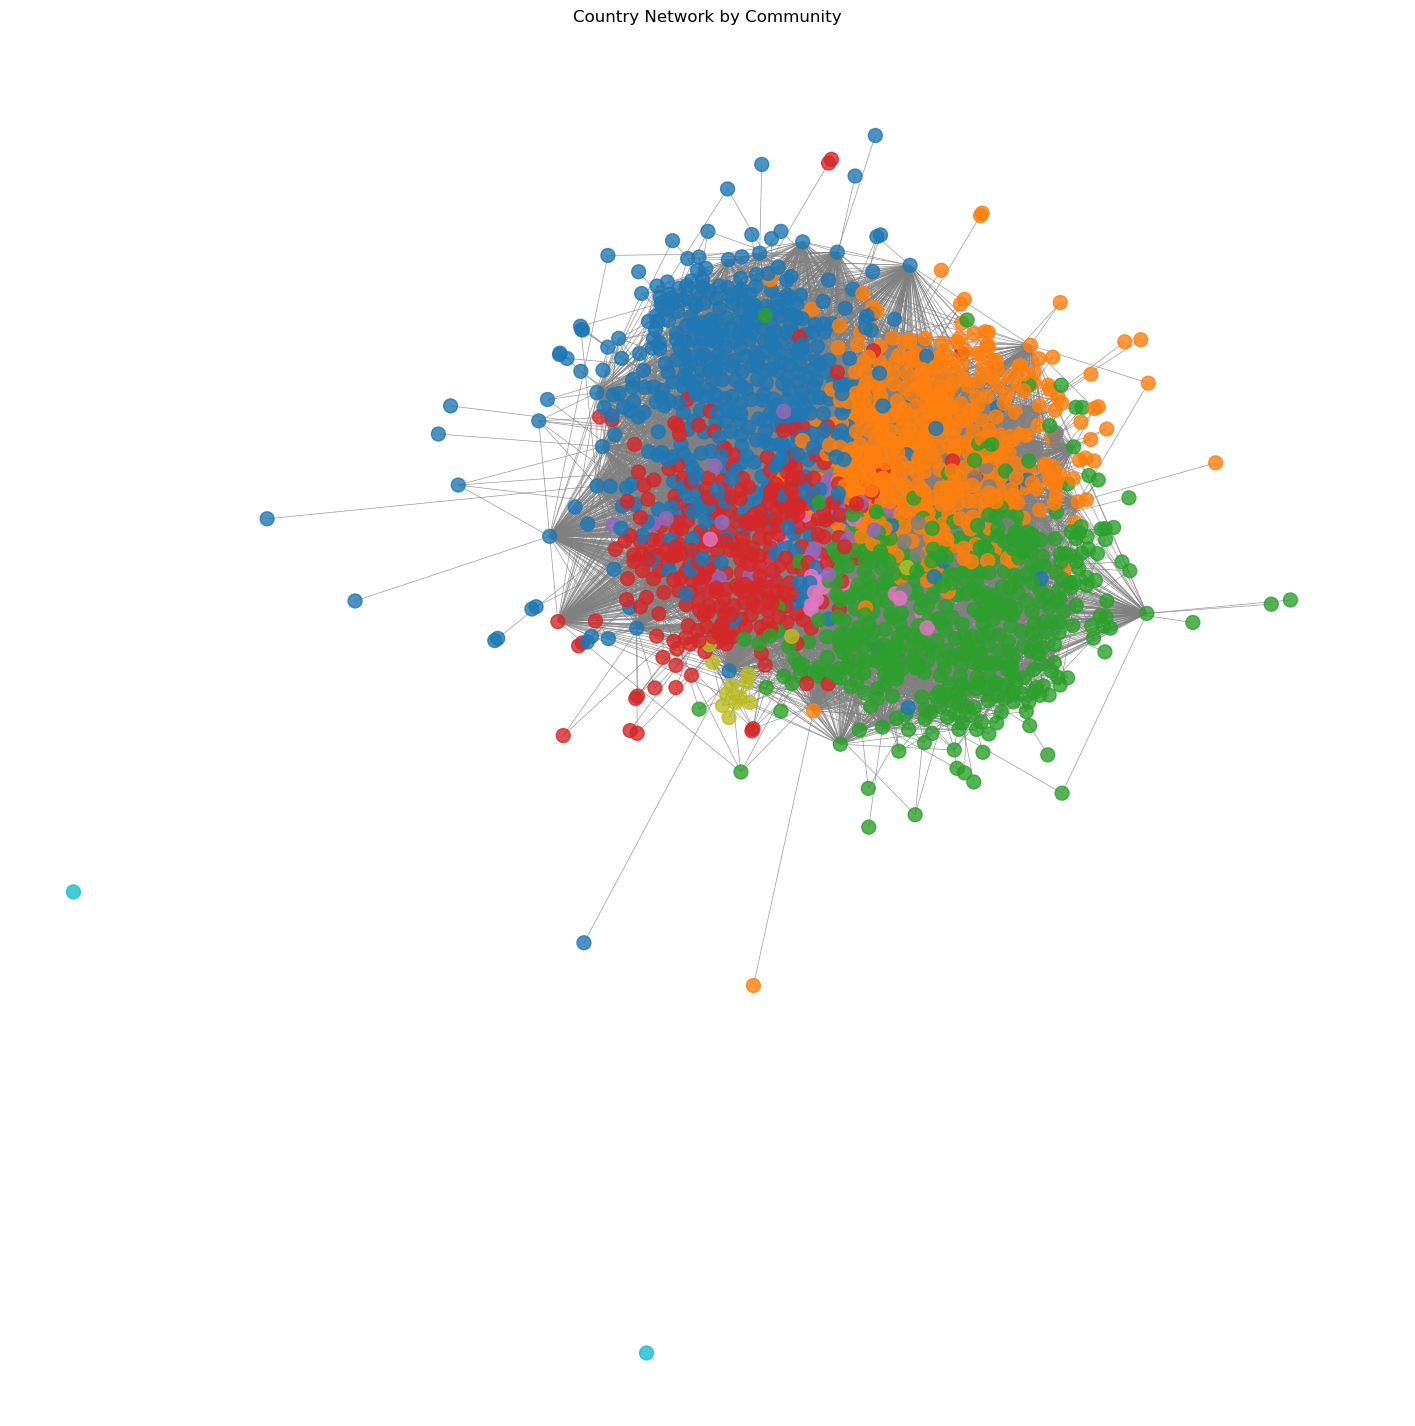

In [11]:
# Select the 10 largest communities
largest_communities = sorted(community_groups.items(), key=lambda x: len(x[1]), reverse=True)[:10]
community_colors = {comm_id: idx for idx, (comm_id, _) in enumerate(largest_communities)}

# Assign colors based on community ID
node_colors = []
for node in filtered_G.nodes():
    comm_id = partition_louvain[node]  # Get community ID for the node
    if comm_id in community_colors:
        node_colors.append(community_colors[comm_id])
    else:
        node_colors.append(-1)  # Assign a neutral color for smaller communities

# Use ForceAtlas2 to get the positions
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,
    scalingRatio=20.0,
    strongGravityMode=False,
    gravity=200,
    verbose=True
)

# Get the positions using ForceAtlas2
positions = forceatlas2.forceatlas2_networkx_layout(filtered_G, iterations=1000)

# Define the color map
cmap = cm.get_cmap('tab10', len(largest_communities) + 1)

# Create the figure
plt.figure(figsize=(18, 18))

# Draw the nodes with colors based on community
nodes = nx.draw_networkx_nodes(
    filtered_G,
    pos=positions,
    node_color=node_colors,
    node_size=100, 
    cmap=cmap,
    alpha=0.8
)

# Draw the edges
edges = nx.draw_networkx_edges(
    filtered_G,
    pos=positions, 
    width=0.5,
    edge_color='gray',
    alpha=0.8
)

# Add a color bar to indicate community IDs
#plt.colorbar(nodes, label="Community ID", ticks=list(range(len(largest_communities) + 1)), boundaries=list(range(len(largest_communities) + 1)))
plt.title('Country Network by Community')

# Show the plot
plt.axis('off')
plt.show()


*Figure 1. Visualization of the country artist network categorized by Louvain communities. Each color represents one of the ten largest communities identified within the network.*

The network is structured around a main core made up of various interconnected clusters, with each color probably indicating a different type of music genre. Although these clusters do overlap, they generally maintain their own specific areas, highlighting that while genres have their own identities, they also have some shared characteristics. Around this central core, there are smaller groups that are loosely connected and some isolated nodes, which could symbolize unique musicians. The differences in the sizes of the clusters imply that certain genres have a larger number of artists compared to others.

# Part 2: TF-IDF to understand genres and communities 

<div style="border: 1px solid white; padding: 10px;">

The questions below  are based on Lecture 7, part 2, 4, 5, 6 (and a little bit on part 3).

* Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
* Calculate and visualize TF-IDF for the genres and communities.
* Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.

</div>

<font color='skyblue'>Answer 1 Part 2: **Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities**</font>

The Term Frequency - Inverse Document Frequency is a widely used statistical method in natural language processing and information retreval. It measures how importnat a term is within a document relative to a collection of documents.

TF-IDF scores a word by multiplying the word's Terd Frequency (TF) with the Inverse Document Frequency (IDF).

The TF is the number of times the term appears in a document compared to the total number of words in the document, whereas the IDF reflects the poportion of documents in the corpus that contain the term.

Words unique to a small percentage of documents receive higher importance values than cords common across all documents.

<font color='skyblue'>Answer 2 Part 2: **Calculate and visualize TF-IDF for the genres and communities**</font>

In [18]:
import re
import math
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Ensure necessary NLTK resources are downloaded
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Initialize dictionary to hold aggregated text for each genre
genre_texts = {}

# Iterate through each artist in filtered_G
for artist, data in filtered_G.nodes(data=True):
    genres = data.get('genres', [])

    # Load and clean text
    with open(f"{SAVE_DIR}/{artist.replace(' ', '_')}.txt", "r", encoding="utf-8") as file:
        text = file.read()

        # Remove Wikipedia templates and markup
        text = re.sub(r"\{\{.*?\}\}", "", text)  # Remove templates like {{BLP refimprove}}
        text = re.sub(r"\[\[.*?\|", "", text)  # Remove links with custom text [[link|text]]
        text = re.sub(r"\]\]", "", text)  # Remove remaining brackets from links
        text = re.sub(r"\[\[|\]\]", "", text)  # Remove any remaining double square brackets
        text = re.sub(r"<.*?>", "", text)  # Remove HTML-like tags (e.g., <ref>)
        text = re.sub(r"\|.*?\n", "\n", text)  # Remove infobox fields
        text = re.sub(r"==+.*?==+", "", text)  # Remove section headers like ==Biography==
        text = re.sub(r"\n+", "\n", text)  # Replace multiple newlines with a single newline

        # Remove specific unwanted words and patterns
        text = re.sub(r"(style|width|height|fontsize|billboard|ref|name)[\w\-\d]*", "", text)  # Remove style tags, ref tags, etc.
        text = re.sub(r"\d+em", "", text)  # Remove occurrences of numbers followed by "em" (e.g., "3em")
        text = re.sub(r"usbr|christbr", "", text)  # Remove artifacts like "usbr" and "christbr"

        # Further clean text by removing non-alphabetic characters and extra spaces
        text = re.sub(r"[^a-zA-Z\s]", " ", text)  # Remove all non-alphabetic characters
        text = text.lower()  # Convert text to lowercase
        text = re.sub(r"\b\w{1,2}\b", "", text)  # Remove very short words (1-2 characters)
        text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespace

        # Remove stop words and lemmatize
        words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
        text = ' '.join(words)

        # Aggregate text for each genre
        for genre in genres:
            if genre not in genre_texts:
                genre_texts[genre] = ""
            genre_texts[genre] += " " + text

# Print genre_texts length
print("Genre's text length:")
for genre, text in genre_texts.items():
    print(f"{genre}: {len(text)}")


Genre's text length:
country: 7385950
outlaw country: 297556
country rock: 1334226
ccm: 44665
gospel: 1211507
folk: 1446478
folk rock: 610928
soft rock: 439816
americana: 1067021
country pop: 915713
honky-tonk: 187741
neotraditional country: 156966
texas country: 75102
western swing: 212476
christian music: 5456
alternative metal: 21
post-grunge: 9219
nu metal: 4179
alternative country: 487430
soul: 276756
jazz: 483741
pop: 1725405
rock: 1127892
progressive country: 306000
latin: 46598
nashville sound: 223113
rockabilly: 699635
traditional pop: 228225
adult contemporary: 82666
tropical rock: 24909
calypso: 21310
easy listening: 118654
blues: 904697
countrypolitan: 49578
western: 220168
red dirt: 47194
bakersfield sound: 104482
rock and roll: 569271
alternative: 70603
country music: 131182
and: 21930
roots rock: 301756
bluegrass: 840975
old-time music: 50655
american folk music: 6228
old-time: 92235
irish traditional music: 3720
southern rock: 365013
blues rock: 320818
hard rock: 216134

In [32]:
# Tokenize the text for each genre
genre_tokens = {genre: word_tokenize(text) for genre, text in genre_texts.items()}

# Count word frequencies for each genre and filter out words appearing less than 5 times
genre_word_counts = {genre: Counter(tokens) for genre, tokens in genre_tokens.items()}
genre_word_counts = {genre: {word: count for word, count in counts.items() if count >= 5} for genre, counts in genre_word_counts.items()}

In [33]:
# Generate TF list for the top 15 genres
all_genres = [genre for genres in genre_data.values() for genre in genres]
top_genres = [genre for genre, _ in Counter(all_genres).most_common(15)]
genre_tf = {genre: {word: count for word, count in counts.items()} for genre, counts in genre_word_counts.items() if genre in top_genres}

In [34]:
tf_list_15 = []

# Display the top 15 words for each genre
for genre, tf_list in genre_tf.items():
    # Get the top 15 most common words
    top_words = Counter(tf_list).most_common(15)

    # Save the top words for each genre in a list
    tf_list_15.append((genre, top_words))
    
    print(f"Top 15 words for {genre}:")
    for word, count in top_words:
        print(f"{word} {count}")
    print("\n")

Top 15 words for country:
category 20497
country 16237
album 14481
scope 13982
row 12184
music 11066
song 9768
american 8738
record 8260
released 8074
singer 7943
year 7737
single 7342
artist 7135
songwriter 5531


Top 15 words for country rock:
album 3200
category 2895
country 2417
band 1982
music 1721
song 1600
released 1586
scope 1463
american 1410
row 1212
record 1210
year 1153
single 1100
artist 1008
rock 996


Top 15 words for gospel:
category 2312
country 2229
album 1803
music 1779
song 1575
american 1192
year 1128
record 1074
singer 970
artist 920
first 862
one 846
released 800
also 776
time 764


Top 15 words for folk:
category 3538
album 2841
song 2096
music 1979
american 1701
country 1669
singer 1374
record 1341
released 1311
year 1263
artist 1127
scope 1073
http 1025
songwriter 904
award 893


Top 15 words for folk rock:
album 1556
category 1180
band 961
song 854
music 659
released 659
record 602
american 575
country 456
rock 447
year 445
new 403
singer 386
scope 367
artist

The above lists highlight the top 15 music genres alongside their most frequently occurring words.

In [36]:
# log-normalize Tf for all the genres
tf_scores = {}
for genre, word_list in genre_tf.items():
    tf_scores[genre] = {}  # Initialize an empty dictionary for each genre
    for word, count in word_list.items():
        tf_scores[genre][word] = 1 + math.log(count)

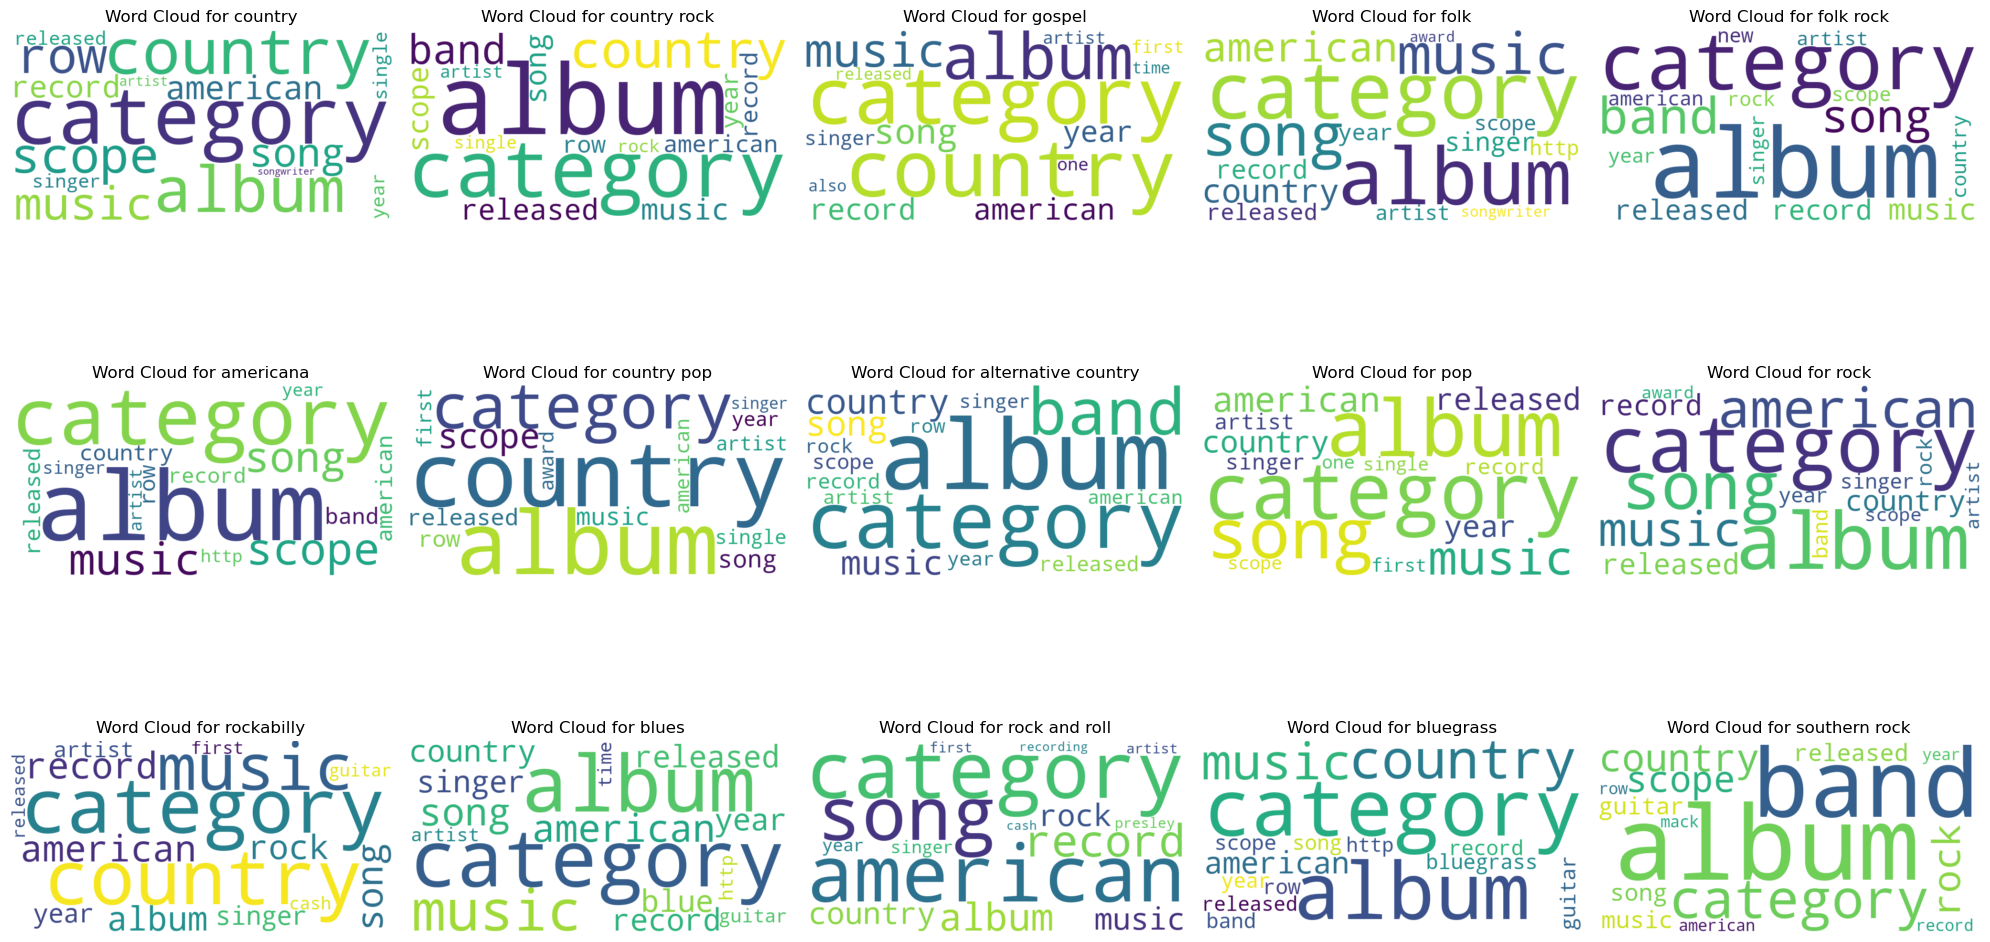

In [25]:
# Prepare Data
genre_texts = {}
for genre, tf_list in tf_list_15:
    text = ' '.join([word for word, freq in tf_list])
    genre_texts[genre] = text

# Generate Word Clouds
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))  # Adjust the number of rows and columns based on the number of genres
axes = axes.flatten()

for ax, (genre, text) in zip(axes, genre_texts.items()):
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                          stopwords=set(stopwords.words('english')), collocations=False).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Word Cloud for {genre}")

plt.tight_layout()
plt.show()

*Figure 2. Word clouds representing the most prevalent terms associated with the 15 most popular genres.*

In [ ]:
# log-normalize Tf for all the genres
tf_scores = {}
for genre, word_list in genre_tf.items():
    tf_scores[genre] = {}  # Initialize an empty dictionary for each genre
    print(f"Genre: {genre}")
    for word, count in word_list.items():
        tf_scores[genre][word] = 1 + math.log(count)
        

Genre: country
Genre: country rock
Genre: gospel
Genre: folk
Genre: folk rock
Genre: americana
Genre: country pop
Genre: alternative country
Genre: pop
Genre: rock
Genre: rockabilly
Genre: blues
Genre: rock and roll
Genre: bluegrass
Genre: southern rock


<font color='yellow'>**Esta celda de arriba está repetida, no?**</font>

In [ ]:
# Calculate the inverse document frequency (IDF) for each word

# Total number of genres
N = len(genre_tf) 
print(f"Total number of genres: {N}")

# Initialize a Counter to store document frequencies
df_counts = Counter()  

# Calculate document frequency for each word
for genre, word_list in genre_tf.items():
    df_counts.update(word_list.keys())

# Calculate IDF for each word
idf_scores = {}
for word, df in df_counts.items():
    idf_scores[word] = math.log(N / df)

# Print IDF scores for the top 15 genres for verification
print(f"IDF scores for the top 15 genres:")
for word, idf in idf_scores.items():
    print(f"{word}: {idf}")


Total number of genres: 15
IDF scores for the top 15 genres:
infobox: 0.0
musical: 0.0
artist: 0.0
tanya: 0.4054651081081644
denise: 1.6094379124341003
tucker: 0.14310084364067324
born: 0.0
october: 0.0
american: 0.0
country: 0.0
music: 0.0
singer: 0.0
songwriter: 0.0
first: 0.0
hit: 0.0
delta: 0.5108256237659907
dawn: 0.6286086594223741
age: 0.0
career: 0.0
became: 0.0
one: 0.0
child: 0.0
performer: 0.0
mature: 1.0986122886681098
adulthood: 2.70805020110221
without: 0.0
losing: 0.6286086594223741
audience: 0.0
streak: 0.9162907318741551
top: 0.0
biography: 0.0
allmusic: 0.0
several: 0.0
successful: 0.0
album: 0.0
mama: 0.22314355131420976
name: 0.22314355131420976
strong: 0.0
enough: 0.0
bend: 0.5108256237659907
two: 0.0
sparrow: 2.70805020110221
hurricane: 0.06899287148695142
livin: 0.5108256237659907
grammy: 0.0
award: 0.0
best: 0.0
bring: 0.06899287148695142
flower: 0.14310084364067324
shared: 0.06899287148695142
songwriting: 0.0
song: 0.0
http: 0.0
www: 0.0
vulture: 2.014903020542

<font color='yellow'>**Maybe delete this print and the next one?**</font>

In [28]:
# Calculate TF-IDF scores for each word in each genre
tfidf_scores = {}
for genre, word_list in genre_tf.items():
    tfidf_scores[genre] = {word: tf_scores[genre][word] * idf_scores[word] for word in word_list}

# Print the TF-IDF scores for the top 15 genres
for genre, scores in tfidf_scores.items():
    print(f"TF-IDF scores for {genre}:")
    for word, score in scores.items():
        print(f"{word}: {score}")
    print("\n")


TF-IDF scores for country:
infobox: 0.0
musical: 0.0
artist: 0.0
tanya: 2.1103212555911233
denise: 5.608740883462514
tucker: 0.8666538840406314
born: 0.0
october: 0.0
american: 0.0
country: 0.0
music: 0.0
singer: 0.0
songwriter: 0.0
first: 0.0
hit: 0.0
delta: 2.7492771127824613
dawn: 3.2127395682348343
age: 0.0
career: 0.0
became: 0.0
one: 0.0
child: 0.0
performer: 0.0
mature: 4.5433047653356535
adulthood: 9.437302153780823
without: 0.0
losing: 3.1917840057804825
audience: 0.0
streak: 4.062821380718334
top: 0.0
biography: 0.0
allmusic: 0.0
several: 0.0
successful: 0.0
album: 0.0
mama: 1.2914414606860507
name: 1.2439608052935582
strong: 0.0
enough: 0.0
bend: 2.264994279501546
two: 0.0
sparrow: 11.19912594310396
hurricane: 0.39813610268748617
livin: 2.6737157200685244
grammy: 0.0
award: 0.0
best: 0.0
bring: 0.39453565772553917
flower: 0.7609370350962981
shared: 0.39575680237373156
songwriting: 0.0
song: 0.0
http: 0.0
www: 0.0
vulture: 5.935723257577664
com: 0.0
winner: 0.0
full: 0.0
list

In [44]:
# Identify top 10 words based on TF-IDF scores
top_words_tfidf = {}
for genre, scores in tfidf_scores.items():
    # Sort words by TF-IDF score and get the top 10
    top_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]
    top_words_tfidf[genre] = top_words

    # Print the genre and its top words
    print(f"\nTop 10 words for '{genre}':")
    for word, score in top_words:
        print(f"{word}: {score:.4f}")


Top 10 words for 'country':
seely: 15.6953
chesnutt: 15.1519
wrestling: 15.0966
raye: 14.9237
nolan: 14.8938
britt: 14.8020
pruett: 14.6084
mccreery: 14.6084
milsap: 14.5407
oslin: 14.2895

Top 10 words for 'country rock':
aerosmith: 14.3637
bice: 10.3946
goshorn: 10.2164
lynae: 10.2164
ledoux: 10.1613
kinky: 9.7726
blundell: 9.7726
kamp: 9.6541
beathard: 9.6397
tweedy: 9.4434

Top 10 words for 'gospel':
laine: 12.4782
locklin: 10.5168
breland: 10.0416
mandrell: 9.7876
maddox: 8.8680
realm: 8.6582
pta: 8.6582
quicksilver: 8.2431
lehning: 8.0510
hatcher: 7.9477

Top 10 words for 'folk':
matsson: 12.1768
connors: 10.8940
macneil: 10.7672
carnes: 10.3946
rankin: 10.1256
wheeler: 9.3966
stripe: 9.2906
stompin: 9.2906
valdy: 8.9980
tallest: 8.9436

Top 10 words for 'folk rock':
pecknold: 12.4866
skjelset: 9.8547
cougar: 9.6541
scarecrow: 9.6541
furay: 9.2353
wescott: 9.2017
wargo: 9.2017
fleet: 9.1202
kot: 8.9980
kortchmar: 8.6582

Top 10 words for 'americana':
bingham: 14.4000
keb: 12.764

Thes cell above shows the top 10 words for each genre along with their corresponding TF-IDF scores.

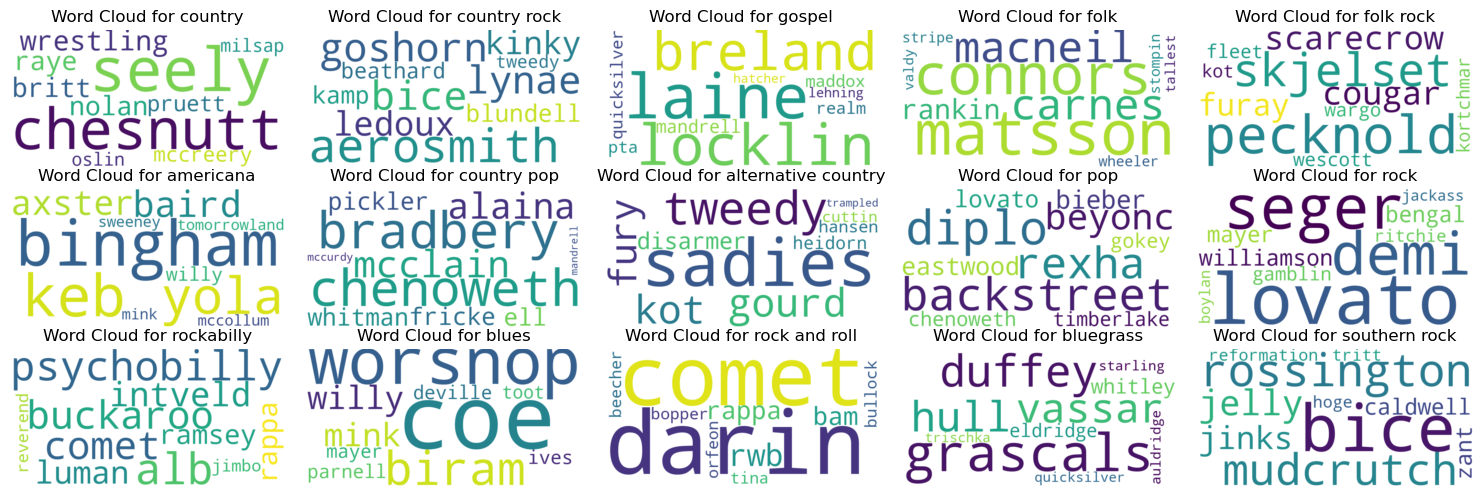

In [30]:
# Number of genres
num_genres = len(top_words_tfidf)

# Determine the number of rows and columns for the subplots
cols = 5
rows = (num_genres + 1) // cols

# Create a figure and a set of subplots
fig, axs = plt.subplots(rows, cols, figsize=(15, 5))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Generate word clouds
for i, (genre, top_words) in enumerate(top_words_tfidf.items()):
    # Prepare a single string with each word repeated according to its TF-IDF score
    wordcloud_input = ' '.join([word for word, score in top_words for _ in range(int(score))])
    
    # Create the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(wordcloud_input)
    
    # Display the word cloud
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].axis('off')
    axs[i].set_title(f"Word Cloud for {genre}")

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

*Figure 3. Word clouds visualizing the top words associated with the top 15 musical genres, with the size of each word corresponding to its TF-IDF score. Higher TF-IDF scores indicate greater importance of the word in distinguishing that genre from others.* 

<font color='skyblue'>Answer 3 Part 2: **Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.**</font>

# Part 3: Sentiment of the artists and communities

<div style="border: 1px solid white; padding: 10px;">

The questions below are based on Lecture 8

* Calculate the sentiment of the Artists pages (OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
* Discuss the sentiment of the largest communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?

</div>

In [12]:
import os
import networkx as nx
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Ensure necessary NLTK data files are downloaded
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<font color='skyblue'>Answer 1 Part 3: **Calculate the sentiment of the Artists pages (OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.**</font>

In [13]:
def calculate_sentiment(tokens, labmt_dict, artist_name):
    """
    Calculate the sentiment of a list of tokens based on the LabMT word list.

    Parameters:
    tokens (list of str): List of tokens to analyze.
    labmt_dict (dict): Dictionary with words as keys and happiness scores as values.

    Returns:
    average_happiness (float): Average happiness score of the tokens.
    """
    # Filter tokens that are in the LabMT word list
    valid_tokens = [token for token in tokens if token in labmt_dict]
    
    # Calculate the average happiness score
    if valid_tokens:
        happiness_scores = [labmt_dict[token] for token in valid_tokens]
        average_happiness = sum(happiness_scores) / len(happiness_scores)
        return average_happiness
    else:
        print(f"No valid tokens found for artist: {artist_name}")
        return None  # Return None if no valid tokens are found

In [14]:
# Load the LabMT word list
filepath = "Data_Set_S1.txt"

labmt_dict = {}
with open(filepath, 'r') as file:
    # Skip the header lines
    next(file)
    next(file)
    
    for line in file:
        parts = line.strip().split('\t')
        if len(parts) > 2 and parts[2] != 'happiness_average':
            try:
                word = parts[0]
                happiness_score = float(parts[2])
                labmt_dict[word] = happiness_score
            except ValueError:
                continue

# Path to the folder containing Wikipedia text files
wiki_folder = "country_artists_wiki"

In [15]:
stop_words = set(stopwords.words('english'))

# Calculate sentiment scores for the network
for node in filtered_G.nodes():
    artist_name = node.replace(" ", "_")
    wiki_file_path = os.path.join(wiki_folder, f"{artist_name}.txt")

    with open(wiki_file_path, 'r') as file:
        text = file.read()
        tokens = word_tokenize(text)
        tokens = [token.lower() for token in tokens] # Convert tokens to lowercase
        tokens = [token for token in tokens if token.isalpha() and token not in stop_words] # Remove non-alphabetic tokens and stopwords
        sentiment_score = calculate_sentiment(tokens, labmt_dict, artist_name)
        filtered_G.nodes[node]['sentiment'] = sentiment_score


No valid tokens found for artist: The_Stonemans


There is one artist that does not contain any of the words in the LabMT list, so we will not take that into account for the statistics.

In [16]:
# Calculate statistics
#sentiment_scores = [data['sentiment'] for _, data in filtered_G.nodes(data=True) if 'sentiment' in data]
sentiment_scores = [data['sentiment'] for _, data in filtered_G.nodes(data=True) if 'sentiment' in data and data['sentiment'] is not None]

average_sentiment = np.mean(sentiment_scores)
median_sentiment = np.median(sentiment_scores)
variance_sentiment = np.var(sentiment_scores)
percentile_25_sentiment = np.percentile(sentiment_scores, 25)
percentile_75_sentiment = np.percentile(sentiment_scores, 75)

# Print statistics
print(f"Average sentiment score: {average_sentiment}")
print(f"Median sentiment score: {median_sentiment}")
print(f"Sentiment score variance: {variance_sentiment}")
print(f"25th percentile sentiment score: {percentile_25_sentiment}")
print(f"75th percentile sentiment score: {percentile_75_sentiment}")

Average sentiment score: 5.871077758057131
Median sentiment score: 5.882613575628007
Sentiment score variance: 0.019768247591262885
25th percentile sentiment score: 5.806785912190963
75th percentile sentiment score: 5.95118625334117


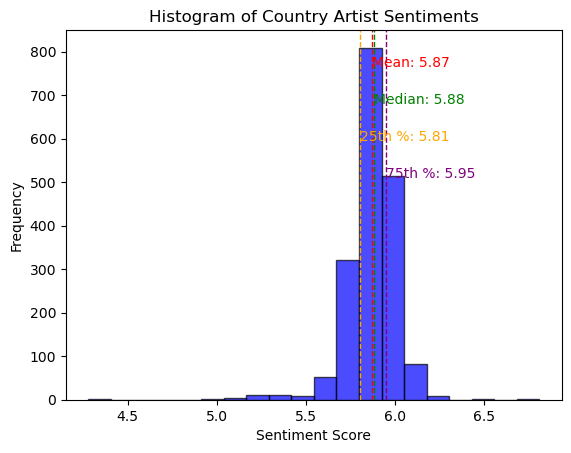

In [17]:
# Plot the histogram of sentiment scores
plt.hist(sentiment_scores, bins=20, alpha=0.7, color='blue', edgecolor='black')

# Add vertical lines for the mean, median, 25th percentile, and 75th percentile    
plt.axvline(average_sentiment, color='red', linestyle='dashed', linewidth=1)
plt.axvline(median_sentiment, color='green', linestyle='dashed', linewidth=1)
plt.axvline(percentile_25_sentiment, color='orange', linestyle='dashed', linewidth=1)
plt.axvline(percentile_75_sentiment, color='purple', linestyle='dashed', linewidth=1)

plt.text(average_sentiment, plt.ylim()[1]*0.9, f"Mean: {average_sentiment:.2f}", color='red')
plt.text(median_sentiment, plt.ylim()[1]*0.8, f"Median: {median_sentiment:.2f}", color='green')
plt.text(percentile_25_sentiment, plt.ylim()[1]*0.7, f"25th %: {percentile_25_sentiment:.2f}", color='orange')
plt.text(percentile_75_sentiment, plt.ylim()[1]*0.6, f"75th %: {percentile_75_sentiment:.2f}", color='purple')

plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Histogram of Country Artist Sentiments')

plt.show()

*Figure 4. Histogram illustrating the distribution of sentiment scores for artist pages. The x-axis represents the sentiment scores, while the y-axis indicates the frequency of scores within specific ranges. Dashed lines denote key statistical metrics: the mean (red), median (green), 25th percentile (orange), and 75th percentile (purple).*

The analysis of the artists' dataset shows a mostly positive emotional tone, with an average sentiment score of about 5.87 and a median of 5.88. This close similarity indicates that the sentiment scores are evenly distributed, meaning that most artists' pages show a positive sentiment. The low variance of 0.02 further supports this, suggesting that the scores are tightly clustered around the average, with minimal differences. The percentiles reveal that half of the sentiment scores are within a small range, further emphasizing the overall positive sentiment.

However, it is crucial to remember that the neutral tone of Wikipedia text, which aims to present unbiased information, might limit the sentiment scores. This neutrality likely plays a role in the generally positive yet moderate sentiment seen in the dataset.

In [53]:
# Collect sentiment scores and corresponding artist names
artist_sentiment = {
    node: data['sentiment']
    for node, data in filtered_G.nodes(data=True) if 'sentiment' in data
}

# Convert to a list of tuples for sorting
sentiment_list = [(artist, score) for artist, score in artist_sentiment.items() if score is not None]

# Sort by sentiment scores (happiest first)
sorted_sentiment = sorted(sentiment_list, key=lambda x: x[1], reverse=True)

# Get the top 3 happiest artists
happiest_artists = sorted_sentiment[:10]

# Get the top 3 saddest artists
saddest_artists = sorted_sentiment[-10:]

# Display results
print("Top 3 Happiest Artists:")
for artist, score in happiest_artists:
    print(f"{artist}: {score:.3f}")

print("\nTop 3 Saddest Artists:")
for artist, score in saddest_artists:
    print(f"{artist}: {score:.3f}")


Top 3 Happiest Artists:
Flying Burrito Brothers: 6.812
Bacon Brothers: 6.470
Allman Brothers Band: 6.273
The Peasall Sisters: 6.272
Gina Jeffreys: 6.252
Spirit Family Reunion: 6.230
Jasmine Rae: 6.213
Alyssa Micaela: 6.203
Aleyce Simmonds: 6.202
Susan McCann: 6.185

Top 3 Saddest Artists:
JJ Cale: 5.250
Tim Mensy: 5.240
Riley Green (singer): 5.236
Kerry Harvick: 5.203
Joanna Smith: 5.170
Jason Boland & the Stragglers: 5.120
Foggy Mountain Boys: 5.096
Flatt & Scruggs: 5.093
Brian Kelley (musician): 4.982
Jimmie Rodgers (country singer): 4.280


<font color='yellow'>**Talk about this:!**</font>
- Musical Themes: Artists like the Flying Burrito Brothers and Bacon Brothers, who have higher happiness scores, may focus on themes of joy, celebration, and positivity in their lyrics and public persona. In contrast, artists like JJ Cale and Tim Mensy, who have lower scores, might address more somber or reflective themes in their music, which can contribute to a lower sentiment score.
- Genre Influence: Different genres may also influence sentiment. For instance, country music often contains themes of love and loss, which could result in varying emotional expressions.
- Personal Life Events: An artist's personal history, including struggles with mental health, public controversies, or tragedies, may lead to more negative sentiment if those aspects are prominently featured on their Wikipedia pages.


<font color='skyblue'>Answer 2 Part 3: **Discuss the sentiment of the largest communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?**</font>

In [ ]:
community_sentiments = defaultdict(list)

# Gather sentiment scores for each community
for node, community_id in partition_louvain.items():
    sentiment = filtered_G.nodes[node].get('sentiment')
    if sentiment is not None:  # Only consider nodes with a valid sentiment score
        community_sentiments[community_id].append(sentiment)

# Calculate average sentiment for each community
average_community_sentiments = {
    community_id: np.mean(sentiments) if sentiments else None
    for community_id, sentiments in community_sentiments.items()
}

# Display the average sentiment for each community
for community_id, average_sentiment in average_community_sentiments.items():
    print(f"Community {community_id}: Average Sentiment = {average_sentiment:.2f}" if average_sentiment is not None else f"Community {community_id}: No valid sentiment scores.")

Community 8: Average Sentiment = 5.84
Community 2: Average Sentiment = 5.86
Community 3: Average Sentiment = 5.91
Community 4: Average Sentiment = 5.86
Community 6: Average Sentiment = 5.87
Community 5: Average Sentiment = 5.96
Community 0: Average Sentiment = 6.07
Community 1: Average Sentiment = 5.89
Community 7: Average Sentiment = 5.92
Community 9: Average Sentiment = 5.84
Community 10: Average Sentiment = 5.90


<font color='yellow'>**Write discussion and compare with  TF-IDF results**</font>